![Variance Reduction Methods for Convex Distributed Optimization](https://i.imgur.com/lL5vDTc.png)

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

# I. Theory

## 1. Intuition behind variance reduction methods

We consider the unconstrained optimization problem of minimizing a finite sum (of L-smooth convex functions) such as an empirical risk $R_n$.

$$ \textrm{min}_{x\in \mathbb{R}^d} \  f(x) = \frac{1}{n} \sum_{i=1}^n f_i(x)$$

In a large dataset, there is often redundancy in the terms of the sum $f_i$. The gradient of the $f_i$ can therefore be a good approximation of the batch gradient $\nabla f$. The SGD method takes advantage of this property to reduce the complexity of descent algorithms. One of the limits of SGD however, is the often large variance of the gradient estimates $\nabla f_i$. Is it possible to reduce the variance of the gradient estimates used at each step?

Variance reduction methods that use *gradient aggregation* are based on the following observation:

>Consider $X$ and $Y$ two random variables and $Z := X - Y + \mathbb{E}[Y]$, we have,
>
>- $\mathbb{E}[Z] = \mathbb{E}[X]$, therefore $Z$ is an unbiased estimate of $X$.
>- $Var(Z) = Var(X) + Var(Y) - 2cov(X,Y)$, therefore, if $X$ and $Y$ are positively corellated and if $cov(X, Y)$ is big enough, $Var(Z)$ is reduced compared to $cov(X)$.

Take $X = \nabla f_i$. 

A consequence of this observation is that, if we find $Y$ such that $Y$ is positively correlated to $X$, we can build a new stochastic vector which is still close to the batch gradient in expectation and which has a smaller variance than $\nabla f_i$. 

We have access to such a $Y$: in fact it is likely that from one iteration to the other, the descent directions do not differ a lot. It follows that these directions are likely to be positively correlated.

SVRG and SAGA are two different ways of building $Y$. 

### SAGA

At iteration k of the SAGA algorithm, the following update is executed:

$$
\begin{cases}
i \textrm{ chosen randomly in } \{1...n\}\\
x_{k+1} \leftarrow x_{k} - \gamma\big(\nabla f_i(x_k) - \alpha_i + \bar{\alpha}\big) \\
\alpha_i \leftarrow \nabla f_i(x) 
\end{cases}
$$

where $(\alpha_i)_{i=1}^n$ are gradients evaluated at previous iterates and $\bar{\alpha}=\frac{1}{n}\sum^n_{i=1}\alpha_i$.


Here 
$\begin{cases}
X =\nabla f_i(x_k) \\
Y = \alpha_i \\
\mathbb{E}[Y] = \frac{1}{n}\sum^n_{i=1}\alpha_i = \bar{\alpha}
\end{cases}
$


### SVRG

At iteration k of the SAGA algorithm, we perform the following:

$$
\begin{cases}
\textrm{Compute the batch gradient } \nabla f(x_k)\\
\textrm{Initialise }y_0 = x_k\\
\textrm{for m in 0...M: } 
\begin{cases}
i \textrm{ chosen randomly in } \{1...n\} \\
y_{m+1} \leftarrow y_{m} - \gamma\big(\nabla f_i(y_m) - \nabla f_i(x_k) + \nabla f(x_k)) 
\end{cases}\\
x_{k+1} \leftarrow y_{M}
\end{cases}
$$

Here 
$\begin{cases}
X =\nabla f_{i_m}(y_m) \\
Y =\nabla f_{i_m}(x_k) \\
\mathbb{E}[Y] = \frac{1}{n}\sum^n_{i=1}\nabla f_i(x_k) = \nabla f(x_k)
\end{cases}
$



## 2. Comparison with other optimization algorithms

Let's see how these methods compare in terms of worst-case complexity expectation, i.e the number of gradient evaluations $k$ necessary to ensure $\mathbb{E}[x_k - f*] \le \epsilon$ (note that our objective is considered $L$-smooth thanks to the $L_2$ regularisation term):


|  |      Convex objective $(\mu = 0)$      |                 Strongly convex objective $(\mu > 0)$               |
|:----------------------------|:--------------------------------------:|:--------------------------------------------------------------------:|
| GD                         |     $O\big(\frac{n}{\epsilon}\big)$    |       $O\big(n\frac{L}{\mu}\textrm{log}\frac{1}{\epsilon}\big)$      |
| SGD                        |    $O\big(\frac{1}{\epsilon^2}\big)$   |       $O\big(\frac{L}{\mu}\textrm{log}\frac{1}{\epsilon}\big)$       |
| SAG, SAGA, SVRG            | $O\big(\frac{\sqrt{n}}{\epsilon}\big)$ | $O\big(\big(n+\frac{L}{\mu}\big)\textrm{log}\frac{1}{\epsilon}\big)$ | 

<br>

Although SAG, SAGA, SVRG present fast rates of convergence, they are not always superior to SG:
- In the large scale setting, i.e. a very lage $n$, they are **comparable to batch gradient descent!** 
- Note also SAGA needs to store $n$ gradients $\nabla f_i(x_k)$ in memory which wich is prohibiting for a very large $n$ (although when $f_i(x_k) = g(X[i]^Tx_k)$, it is possible to avoid storing them by instead computing $\nabla f_i(x_k) = \nabla g(X[i]^Tx_k)X[i]$ from the feature vector $X[i]$)  

# II. Implementation

⚠️ *I implemented all the libraries imported below. None of these modules (except datasets) come from Sklearn. See associated source code.*

We study the minimization of the empirical risk $R_n$ for a logistic regression model:

$$ \textrm{min}_{w\in \mathbb{R}^d} \  R_n(w) = \frac{1}{n} \sum_{i=1}^n f_i(w) + r(w),  
\textrm{ where }  
\begin{cases}
f_i(w) = \textrm{LogisticLoss}(y_i, w^T X_i) \\
r(w)   = \lambda_1 \|w\| + \frac{1}{2} \lambda_2 \|w\|^2 
\end{cases} $$

What this implementation brings:
- All the solvers have support for composite objectives where a proximal operator is used on the regularizer.
- The implementation is factorized and easy to extend (adding new optimizers, changing the loss function etc.).
- The code is flexible and easy to use (the syntax was inspired by `Sklearn`).

## 1. Data

>```python
>datasets.load_student_data(file, split=0.25)
>```
>
>This function does all the preprocessing required on the dataset and splits it into training and testing data (`split` is the proportion of testing data).

In [2]:
from datasets import load_student_data

X_train, X_test, y_train, y_test = load_student_data('data/student-mat.csv', split=0.25)

## 2. Logistic Regression

>```python
>class linear_model.LogisticRegression(solver='GD', l1=0.02, l2=0.1, max_iter=50)
>```
>
>**Parameters:**
>- `l1` and `l2`: Used to specify the $L_1$ and $L_2$ regression penalty
>- `solver`: Optimization method, to be chosen among `‘GD’`, `‘SGD’`, `‘SAG’`, `‘SAGA’`, `‘SVRG’`
>- `max_iter`: Number of iterations (i.e. number of descent steps). Note that for GD or SVRG, one iteration is one epoch i.e, one pass through the data, while for SGD, SAG and SAGA, one iteration uses only one data point.
>
>**Attributes:**
>- `coef_`: Coefficient of the features in the decision function.
>
>**Methods**
>- `fit(X,y)`: Fit the model according to the given training data.
>- `predict(X)`: Predict class labels for samples in X.
>- `decision_function(X)`: Predict confidence scores for samples in X.
>- `score(X, y)`: Returns the mean accuracy on the given test data and labels.


In [3]:
from linear_model import LogisticRegression

epochs = 30
n = len(y_train)

clf0 = LogisticRegression(solver='GD', l1=0.02, l2=0.1, max_iter=epochs)
clf1 = LogisticRegression(solver='SGD', l1=0.02, l2=0.1, max_iter=epochs*n)
clf2 = LogisticRegression(solver='SAG', l1=0.02, l2=0.1, max_iter=epochs*n)
clf3 = LogisticRegression(solver='SAGA', l1=0.02, l2=0.1, max_iter=epochs*n)
clf4 = LogisticRegression(solver='SVRG', l1=0.02, l2=0.1, max_iter=epochs)

clf0.fit(X_train, y_train)
clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

## 3. Evaluation

>```python
>visuals.learning_curve(Name1=clf1, Name2=clf2)
>```
>This function takes **any number of parameters** `Name=clf`, where `Name` is a display name and `clf` is a fitted classifier. It plots the evolution of the empirical risk with regards to the number of epochs. 


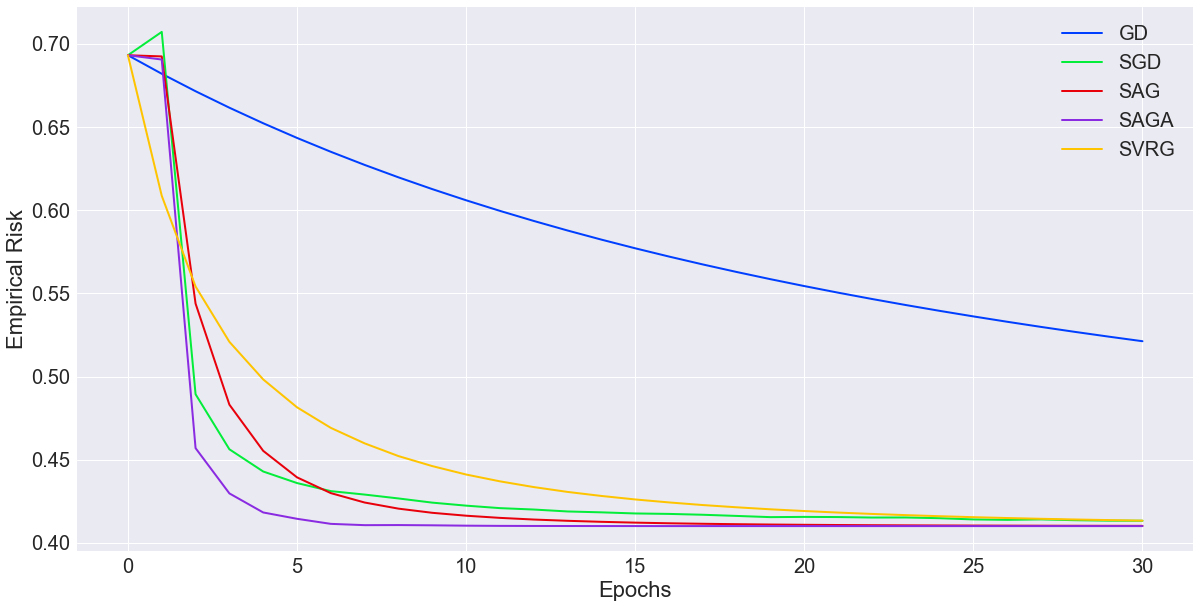

In [4]:
from visuals import learning_curve

learning_curve(GD=clf0, SGD=clf1, SAG=clf2, SAGA=clf3, SVRG=clf4)

In [5]:
for clf, name in zip([clf0, clf1, clf2, clf3, clf4], ['GD', 'SGD', 'SAG', 'SAGA', 'SVRG']):
    print(name + ':' \
          + "\tAccuracy on training set: {0:0.1f}%".format(100*clf.score(X_train, y_train)))
    print("\tAccuracy on testing set:  {0:0.1f}%".format(100*clf.score(X_test, y_test)))

GD:	Accuracy on training set: 88.5%
	Accuracy on testing set:  84.8%
SGD:	Accuracy on training set: 93.9%
	Accuracy on testing set:  88.9%
SAG:	Accuracy on training set: 94.3%
	Accuracy on testing set:  88.9%
SAGA:	Accuracy on training set: 94.3%
	Accuracy on testing set:  88.9%
SVRG:	Accuracy on training set: 93.6%
	Accuracy on testing set:  88.9%


## 3. Parallelization

The advantage of parallelization on a personal computer and for a relatively small dataset is not obvious. In fact, in this setting, the overhead of synchronisation is enough to make the parallel version of SGD slower.

*Note 1: The number of jobs is chosen automatically depending on the number of detected CPUs*.

*Note 2: The `hogwildSGD` solver uses the [joblib](https://joblib.readthedocs.io/en/latest/parallel.html) library*.

Computation time of serial SGD 0.485 seconds
Detected CPU:  4
Computation time of parallel SGD 1.142 seconds


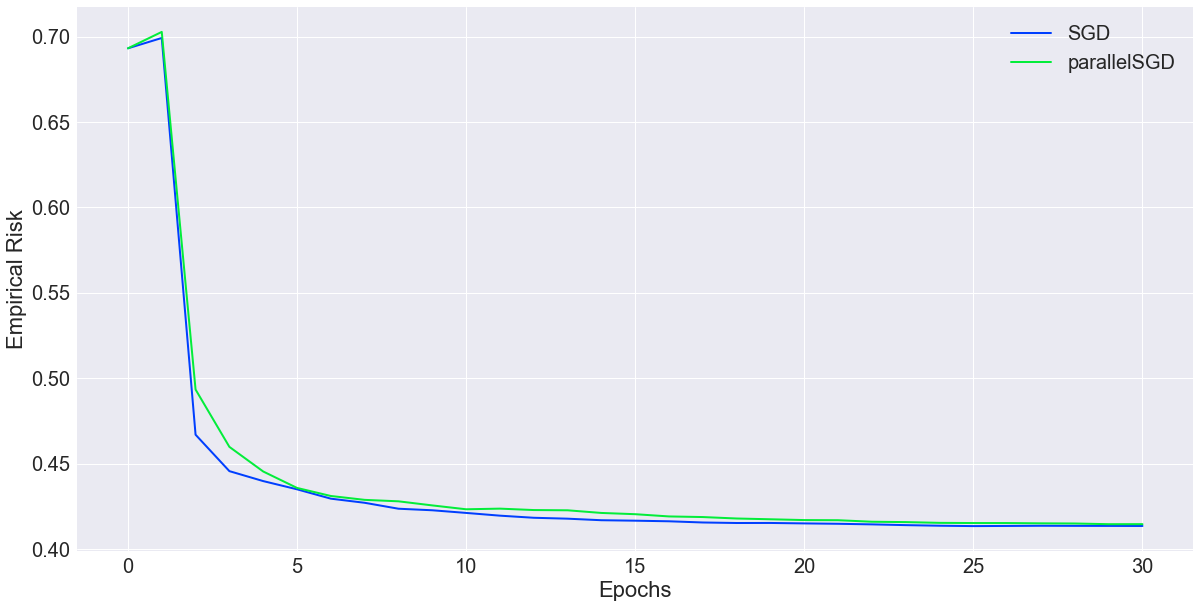

In [6]:
from tools import Time

epochs = 30
n = len(y_train)

clf5 = LogisticRegression(solver='SGD', l1=0.02, l2=0.1, max_iter=epochs*n)
clf6 = LogisticRegression(solver='hogwildSGD', l1=0.02, l2=0.1, max_iter=epochs*n)

with Time() as runtime:
    clf5.fit(X_train, y_train)
print("Computation time of serial SGD {0:0.3f} seconds".format(runtime()))

with Time() as runtime:
    clf6.fit(X_train, y_train)
print("Computation time of parallel SGD {0:0.3f} seconds".format(runtime()))

learning_curve(SGD=clf5, parallelSGD=clf6)

# References

>- [Bottou, Curtis and Jorge Nocedal, 2016](https://arxiv.org/abs/1606.04838)
>- [Francis Bach's NeurIPS tutorial, 2016](https://www.di.ens.fr/~fbach/fbach_tutorial_vr_nips_2016.pdf)
>- [Julien Mairal's P.A.I.S.S. talk, 2018](https://project.inria.fr/paiss/files/2018/07/mairal-large-scale-optim.pdf)
>- [Defazio and Bach, 2014](https://arxiv.org/pdf/1407.0202.pdf)
>- [Johnson and Zhang, 2013](https://papers.nips.cc/paper/4937-accelerating-stochastic-gradient-descent-using-predictive-variance-reduction.pdf)
>- [Niu, Recht, Re and Wright, 2011](https://arxiv.org/abs/1106.5730)
>- [Pedregosa et al., 2011](http://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html)